# Analysis of Multi-Omics Data of CLL Patients

## Overview

The data consist of $N=200$ blood samples from a cohort of Chronic Lymphocytic Leukemia (CLL) patients, where four omics data types were profiled: DNA methylation (450K Illumina microarray), bulk RNA-seq, somatic mutations and ex-vivo drug response assay. The dataset was introduced in detail by @Dietrich:JCI:2018 and can be downloaded [here](http://bioconductor.org/packages/release/data/experiment/html/BloodCancerMultiOmics2017.html). 
Its MOFA analysis was originally published by @Argelaguet:MolSysBiol:2018, and refined by @Lu:NatCancer:2021.

A detailed explanation of the data can be found [in this paper](https://www.jci.org/articles/view/93801). 

In [364]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [365]:
import scanpy as sc
import muon as mu
import pandas as pd
import numpy as np
import seaborn as sns
import mofax as mfx
import matplotlib.pyplot as plt

## Load Data

We load the data and ensure we have features in the columns, and samples in the rows:

In [366]:
mrna = pd.read_csv("data/cll_mrna.csv", index_col=0).T
drugs = pd.read_csv("data/cll_drugs.csv", index_col=0).T
mutations = pd.read_csv("data/cll_mutations.csv", index_col=0).T
methylation = pd.read_csv("data/cll_methylation.csv", index_col=0).T

drug_names = pd.read_csv("data/drugs.txt", sep=",", index_col=0)
metadata = pd.read_csv("data/metadata.txt", sep="\t", index_col=0)

print(f"RNA Shape: {mrna.shape}")
print(f"Drugs Shape: {drugs.shape}")
print(f"Mutations Shape: {mutations.shape}")
print(f"Methylation Shape: {methylation.shape}")
print(f"Metadata Shape: {metadata.shape}")
print(f"Drug Names Shape: {drug_names.shape}")

RNA Shape: (136, 5000)
Drugs Shape: (200, 310)
Mutations Shape: (200, 69)
Methylation Shape: (200, 4248)
Metadata Shape: (200, 8)
Drug Names Shape: (91, 4)


## Data Properties

### mRNA expression

The mRNA expression were normalised by library size, followed by a variance stabilizing transformation using [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html) in R: Statistical methods like clustering and PCA, commonly used in exploratory analysis of multidimensional data such as gene expression levels in RNA-Seq data, assume homoskedasticity, where the variability of data points is constant across different mean values. However, RNA-Seq data often exhibit heteroskedasticity, meaning the variance of gene expression levels increases with their mean. This discrepancy necessitates the use of specialized statistical approaches that can accurately account for the variable spread of data points to ensure reliable analysis or require preprocessing the data.

In [367]:
mrna.head()

,ENSG00000244734,ENSG00000158528,ENSG00000198478,ENSG00000175445,ENSG00000174469,ENSG00000188536,ENSG00000186522,ENSG00000196263,ENSG00000198046,ENSG00000144642,...,ENSG00000136492,ENSG00000143198,ENSG00000161653,ENSG00000203778,ENSG00000177599,ENSG00000111328,ENSG00000165474,ENSG00000164061,ENSG00000166816,ENSG00000165972
H045,4.558644,11.741854,8.921456,12.686458,2.644946,2.644946,11.473792,9.680574,10.323723,11.137333,...,7.220013,10.177649,4.667130,7.052534,6.323287,10.059942,1.528848,5.771337,1.528848,5.256267
H109,2.721512,13.287432,2.721512,10.925985,12.648355,1.528848,10.271483,9.986980,10.231973,1.528848,...,7.947078,8.223803,4.775046,6.279164,5.799820,10.361200,1.528848,5.359180,2.383843,7.360436
H024,9.938456,2.341006,12.381452,1.528848,1.528848,6.664661,3.408744,3.657904,3.657904,2.341006,...,8.967320,10.096502,5.815616,6.369060,6.539086,8.152703,1.528848,6.059008,2.341006,5.715771
H056,13.278004,3.232874,8.106266,1.528848,13.565210,9.580385,3.410471,3.565827,3.232874,2.417160,...,8.532982,10.238564,5.902633,5.728777,5.929667,7.737858,2.417160,5.495087,3.232874,5.789100
H079,6.086874,11.940820,4.889503,13.340588,5.476914,3.862678,9.955379,10.244702,10.567114,7.967849,...,7.760580,8.790501,5.929477,5.833956,6.036300,8.274131,2.270282,5.102382,1.528848,6.316072


<Axes: ylabel='Count'>

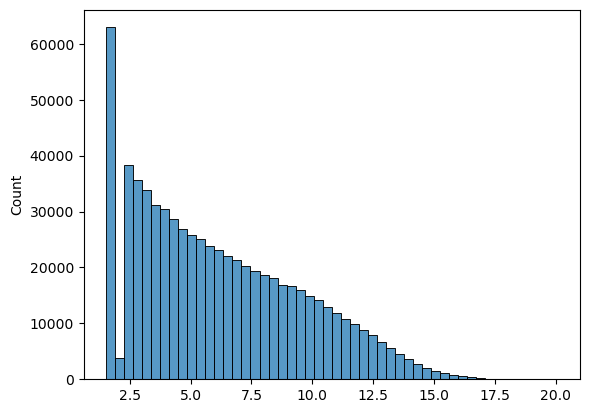

In [368]:
sns.histplot(mrna.values.flatten(), bins=50, kde=False)

### DNA Methylation

DNA methylation was calculated for every CpG site using the [M-value](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-11-587), which provides a better summary statistic for downstream analysis. For the MOFA analysis we selected the top 1% ($N=4248$) most variable sites.

In [369]:
methylation.head()

,cg10146935,cg26837773,cg17801765,cg13244315,cg06181703,cg19626656,cg15207968,cg12755103,cg23651812,cg14287724,...,cg07016730,cg25152348,cg08425796,cg05418105,cg22249529,cg07600533,cg08260245,cg19112186,cg10770023,cg00270625
H045,1.811086,-5.172572,5.411526,-0.118825,5.120384,0.145951,-3.436869,-3.844246,2.075422,3.501829,...,3.547843,0.060132,4.442026,2.861301,5.246799,3.901933,5.713831,5.703520,5.166255,4.911655
H109,-3.997508,1.594870,5.412693,1.043871,1.279480,-3.928433,2.989245,0.393004,4.800121,3.159201,...,0.887926,-0.214753,4.561187,3.919911,5.058302,2.634941,5.107460,1.326244,0.677912,5.281115
H024,-2.844313,0.161170,0.365706,-4.219236,0.721100,-3.418859,-3.250385,-2.691305,0.534854,-4.629484,...,-4.486709,0.121749,-2.841373,-3.607177,0.765651,1.516759,5.676245,5.488636,4.221828,5.379716
H056,-3.338656,-2.093433,0.373634,-1.592196,4.047059,0.226601,2.377386,-2.775075,0.419985,0.312388,...,-4.238214,0.137862,-3.964855,-2.270940,-2.631909,-3.884756,5.950338,5.354059,4.934536,5.366823
H079,-0.019362,3.748980,5.412010,1.416418,5.237422,0.324213,-0.647632,-3.098837,5.397188,3.410770,...,2.758021,0.021011,0.673296,3.455230,-3.140733,-4.238106,6.040756,5.584746,5.095111,5.338470


In [370]:
x = 1 / (1 + np.exp(methylation.values.flatten()))

<Axes: ylabel='Count'>

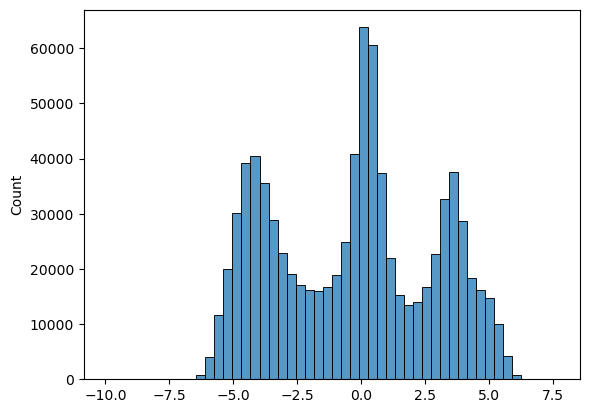

In [371]:
sns.histplot(methylation.values.flatten(), bins=50, kde=False)

### Somatic Mutations
Mutations were assessed using a panel of common cancer mutations and are summarised in a binary format (0=no mutation, 1=mutaton):


In [372]:
mutations.head()

,gain2p25.3,gain3q26,del6p21.2,del6q21,del8p12,gain8q24,del9p21.3,del11q22.3,trisomy12,del13q14_any,...,RASGRF2,RP11.766F14.2,RYR2,SEMA4D,TRDN,UMODL1,VWF,XPO1,ZC3H18,IGHV
H045,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
H109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
H024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
H056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
H079,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: ylabel='Count'>

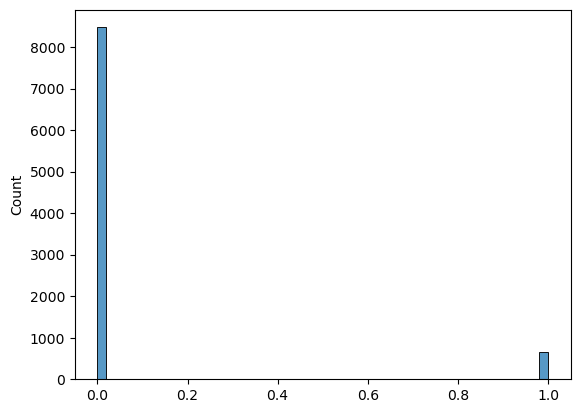

In [373]:
sns.histplot(mutations.values.flatten(), bins=50, kde=False)

### Drugs

The authors measured the effect of multiple drugs *ex vivo* using a high-throughput platform. For each drug they used 5 concentrations. The value reported is the viability score (0=all cells died, 1=no cells died). 

The mapping of Drug ID to Compound and Main Target can be found in App. 6: https://www.jci.org/articles/view/93801/sd/1

In [374]:
drugs.head()

,D_001_1,D_001_2,D_001_3,D_001_4,D_001_5,D_002_1,D_002_2,D_002_3,D_002_4,D_002_5,...,D_172_1,D_172_2,D_172_3,D_172_4,D_172_5,D_CHK_1,D_CHK_2,D_CHK_3,D_CHK_4,D_CHK_5
H045,0.023639,0.046233,0.318747,0.823703,0.896278,0.094328,0.416996,0.684516,0.705886,0.635737,...,0.085584,0.817506,1.1,1.100000,1.046411,1.056821,1.100000,1.040568,0.993331,0.989254
H109,0.073599,0.106230,0.273289,0.717138,0.885000,0.172113,0.504201,0.702193,0.750747,0.746797,...,0.101792,0.827360,1.1,1.100000,1.100000,1.023215,1.100000,1.037670,1.012460,0.957553
H024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H056,0.058139,0.090220,0.232215,0.722574,0.795750,0.187089,0.767374,1.070742,1.032205,1.100000,...,0.501332,0.909873,1.1,1.100000,1.050284,0.915873,1.093643,1.100000,1.074945,1.040403
H079,0.020421,0.047505,0.363896,0.807391,0.879489,0.117735,0.529514,0.788220,0.824481,0.788881,...,0.128200,0.821278,1.1,1.087701,1.022566,1.048188,1.100000,1.100000,1.100000,1.100000


<Axes: ylabel='Count'>

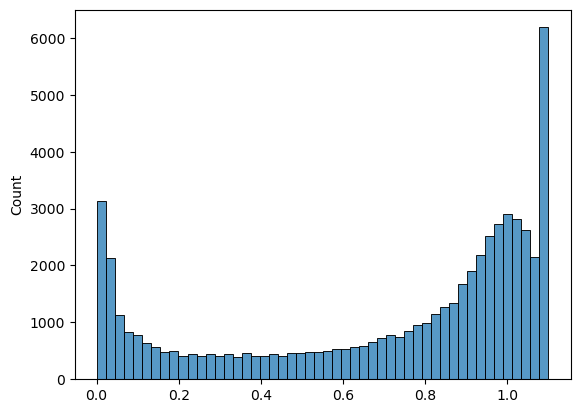

In [375]:
sns.histplot(drugs.values.flatten(), bins=50, kde=False)

### <span style="color:red">Questions</span>

1) Compute and visualize (e.g., using a heatmap) the number of missing samples and features per modality  
  A: ...  
2) What are common strategies to impute these values?  
  A: ...  

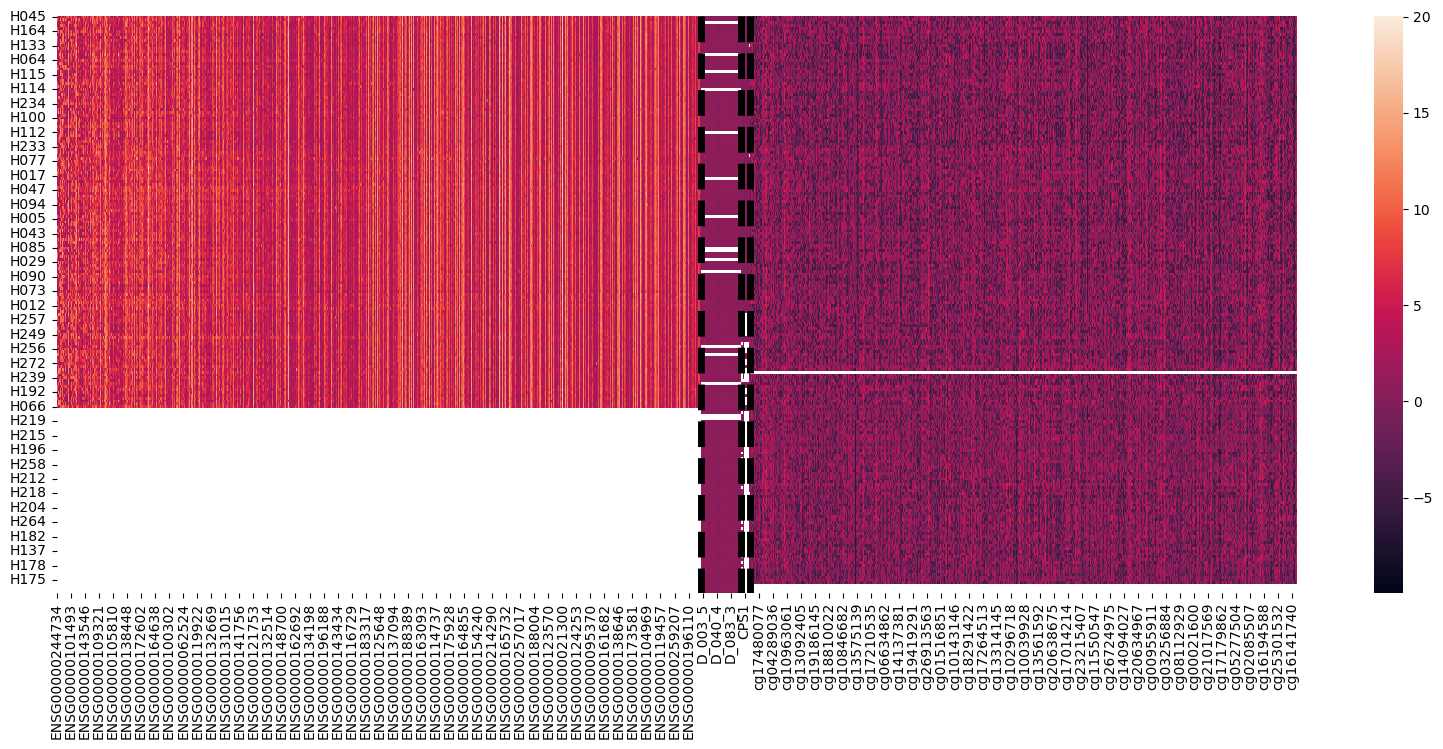

In [376]:
def lined_heatmap(data, vlines=None, **kwargs):
    fig, ax = plt.subplots(1, 1, figsize=(20, 7.5))
    g = sns.heatmap(data, ax=ax, **kwargs)
    if vlines is not None:
        ax.vlines(
            vlines, *sorted(g.get_ylim()), lw=5.0, color="black", linestyles="dashed"
        )
    return g


data = pd.concat([mrna, drugs, mutations, methylation], axis=1)
ax = lined_heatmap(
    data,
    vlines=[
        mrna.shape[1],
        mrna.shape[1] + drugs.shape[1],
        mrna.shape[1] + drugs.shape[1] + mutations.shape[1],
    ],
)

### Metadata

Important columns are:  

- **Gender**: m (male), f (female)
- **Age**: age in years
- **TTT**: time (in years) which passed from taking the sample to the next treatment
- **TTD**: time (in years) which passed from taking the sample to patients' death
- **treatedAfter**: (TRUE/FALSE)
- **died**: whether the patient died (TRUE/FALSE)

In [377]:
metadata.head()

,Gender,age,TTT,TTD,treatedAfter,died,IGHV,trisomy12
sample,,,,,,,,
H005,m,75.265753,0.574949,2.625599,True,False,1.0,0.0
H006,m,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H007,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H008,m,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H010,f,72.780822,2.932238,2.932238,False,False,0.0,0.0


For some of the correlation analysis in the following, we want to treat `sex` (*Gender* is a sociological concept, *sex* a biological. While they are related, in analyses such as here we usually care more about the latter) and `died` as numeric variables, and hence we create these here. 

In [378]:
metadata["sex"] = metadata["Gender"].map({"m": 0, "f": 1})
metadata["died"] = metadata["died"].map({True: 1.0, False: 0.0})

#### Rename mRNA from ENSEMBL IDs
E.g., ENSG00000223972 to gene names DDX11L1

In [379]:
gene_ids = pd.read_csv("data/cll_gene_ids.csv", index_col=0)
cols = list(mrna.columns)

# # # Replace each value in cols with the corrsponding value in the gene_ids dataframe
cols = [gene_ids.loc[gene_ids["GENEID"] == gene, "SYMBOL"].item() for gene in cols]
mrna.columns = cols

# avoid duplicated names with the Mutations view
mutations.columns = [f"m_{x}" for x in mutations.columns]

#### Rename drug names
E.g., D_001 to drug name navitoclax

### <span style="color:red">Questions</span>

1) Replace the drug names

In [380]:
# Create mapping from drug_id to name
mapping = drug_names["name"].to_dict()

# Replace all substrings in drugs.columns as keys with the corresponding values in the mapping
cols = []
for k in drugs.columns:
    for v in mapping.keys():
        if v in k:
            cols.append(k.replace(v, mapping[v]))
            break

drugs.columns = cols

## Data Preprocessing for Analysis

AnnData documentation: https://anndata.readthedocs.io/en/latest/

In [381]:
datasets = pd.concat([mrna, drugs, mutations, methylation], axis=1)

mrna = sc.AnnData(mrna)
methylation = sc.AnnData(methylation)
drugs = sc.AnnData(drugs)
mutations = sc.AnnData(mutations)

### mRNA

To improve the computational efficiency, we focus our analysis on the top `k` highly variable genes. Feel free, to vary this number based on your hardware.

In [19]:
# Select highly variable genes
sc.pp.highly_variable_genes(mrna, n_top_genes=10_000)
mrna = mrna[:, mrna.var.highly_variable]

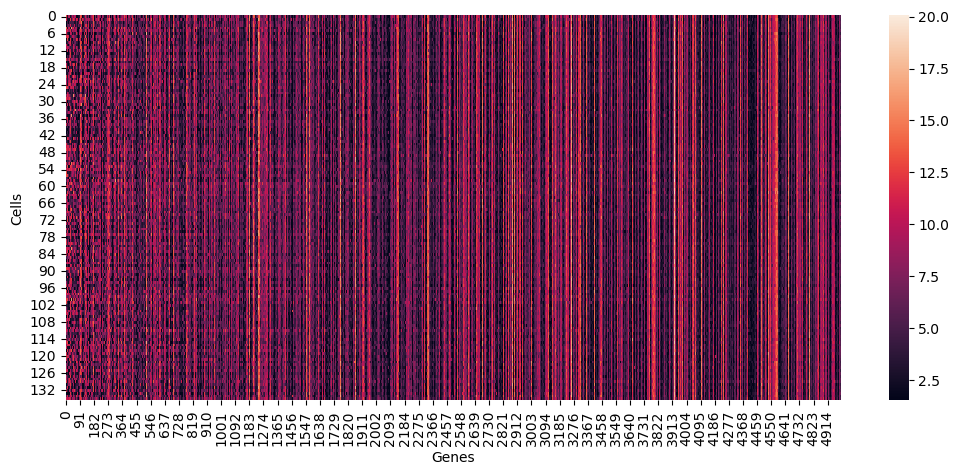

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12.5, 5))
sns.heatmap(mrna.X)
ax.set_xlabel("Genes")
ax.set_ylabel("Cells")
plt.show()

### Create MUON object

Muon is built to handle MuData (multimodal data) objects, similar to how scanpy and AnnData focus on scRNA-seq data in Python, with individual modalities within MuData being represented using AnnData objects.

It's a convenient way to store, manage and process data from multiple modalities. See the package documentation [here](https://muon.readthedocs.io/en/latest/).

In [21]:
mods = {
    "mrna": mrna,
    "methylation": methylation,
    "drugs": drugs,
    "mutations": mutations,
}

mdata = mu.MuData(mods)
mdata.obs = mdata.obs.join(metadata)
mdata

MuData object with n_obs × n_vars = 200 × 9627
  obs:	'Gender', 'age', 'TTT', 'TTD', 'treatedAfter', 'died', 'IGHV', 'trisomy12', 'sex'
  4 modalities
    mrna:	136 x 5000
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg'
    methylation:	200 x 4248
    drugs:	200 x 310
    mutations:	200 x 69

Muon allows you to run a variety of analyses on your data, e.g., MOFA with `muon.pl.mofa`, directly.

## Train a MOFA model

Now, we are going to create a MOFA object and then an integration optimization.

Some selected arguments of the MOFA wrapper are:
- *n_factors*: number of factors
- *likelihoods*: likelihood per view (options are “gaussian”, “poisson”, “bernoulli”). Default is guessed from the data.
- *ard_weights*: use ARD prior on the weights? Default is TRUE if using multiple views.
- *ard_factors*: use ARD prior on the factors? Default is TRUE if using multiple groups.
- *spikeslab_weights*: use spike-slab sparsity prior in the weights? default is TRUE.
- *spikeslab_factors*: use spike-slab sparsity prior in the factors? default is FALSE.
- *convergence_mode*: fast, medium, or slow convergence 
- *use_obs*: optional: strategy to deal with samples (cells) not being the same across modalities ("union" or "intersection")

### <span style="color:red">Questions</span>

1) What about missing data points?  
    A: ...
2) What likelihoods should we pass to the model? Is it a problem, if we chose an incorrect one?  
    A: ...
3) How can we find a good number of factors?  
    A: ...

In [22]:
mu.tl.mofa(
    mdata,
    use_obs="union",
    n_factors=15,
    convergence_mode="slow",
    outfile="models/cll_v3.hdf5",
    save_metadata=True,
    save_data=True,
    verbose=False,
    ard_weights=True,
    ard_factors=True,
    spikeslab_weights=True,
    spikeslab_factors=False,
    seed=42,
)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='mrna' group='group1' with N=200 samples and D=5000 features...
Loaded view='methylation' group='group1' with N=200 samples and D=4248 features...
Loaded view='drugs' group='group1' with N=200 samples and D=310 features...
Loaded view='mutations' group='group1' with N=200 samples and D=69 features...


Model options:
- Automatic Relevance Determination prior on the f

In [23]:
# Load the model with mofax
model = mfx.mofa_model(f"models/cll_v3.hdf5")

In [24]:
# Uncomment the following cell if you want to run the model with different number of factors
# and study the ELBO and Variance Explained

# results = {}
# ve = {}
# for n_factors in [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50]:
#     mu.tl.mofa(
#         mdata,
#         use_obs="union",
#         n_factors=n_factors,
#         convergence_mode="fast",
#         outfile=f"models/cll_v2_{n_factors}.hdf5",
#         save_metadata=True,
#         save_data=True,
#         verbose=False,
#         quiet=True,
#     )

#     results[n_factors] = mfx.mofa_model(f"models/cll_v2_{n_factors}.hdf5").__dict__[
#         "training_stats"
#     ]["elbo"][-1]
#     # Save explained variance
#     x = pd.concat([pd.DataFrame(x.X) for x in mdata.mod.values()], axis=1)
#     m = mfx.mofa_model(f"models/cll_v2_{n_factors}.hdf5")
#     ve[n_factors] = mfx.calculate_r2(Z=m.get_factors().T, W=m.get_weights().T, Y=x)
#     # CLose model
#     m.close()

# Make a plots of the results
fig, ax = plt.subplots(1, 1, figsize=(12.5, 5))
ax.scatter(list(results.keys()), list(results.values()))
ax.plot(list(results.keys()), list(results.values()))
ax.set_xlabel("Number of factors")
ax.set_ylabel("ELBO")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(12.5, 5))
ax.scatter(list(ve.keys()), list(ve.values()))
ax.plot(list(ve.keys()), list(ve.values()))
ax.set_xlabel("Number of factors")
ax.set_ylabel("Variance Explained")
plt.show()

## Analysis and Interpretation of the Results

Scatter plot in MOFA factors coordinates

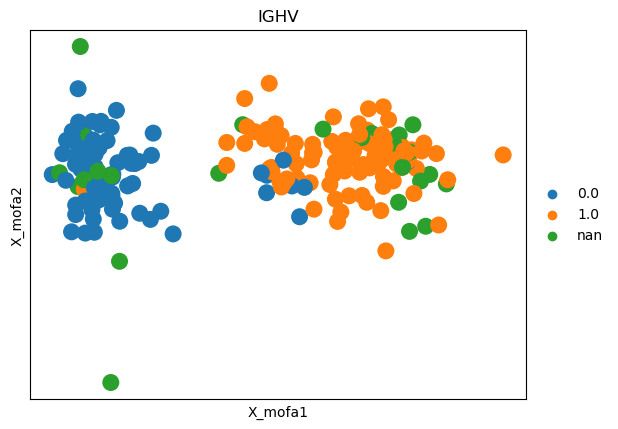

In [25]:
mdata.obs.IGHV = (
    mdata.obs.IGHV.astype(str)
    .astype("category")
    .cat.rename_categories({"M": "mutated", "U": "unmutated"})
)
mu.pl.mofa(mdata, color="IGHV")

# Load the model with mofax
model = mfx.mofa_model("models/cll_v2.hdf5")
model

##### Weights & Factors

Text(0.5, 1.0, 'Weights')

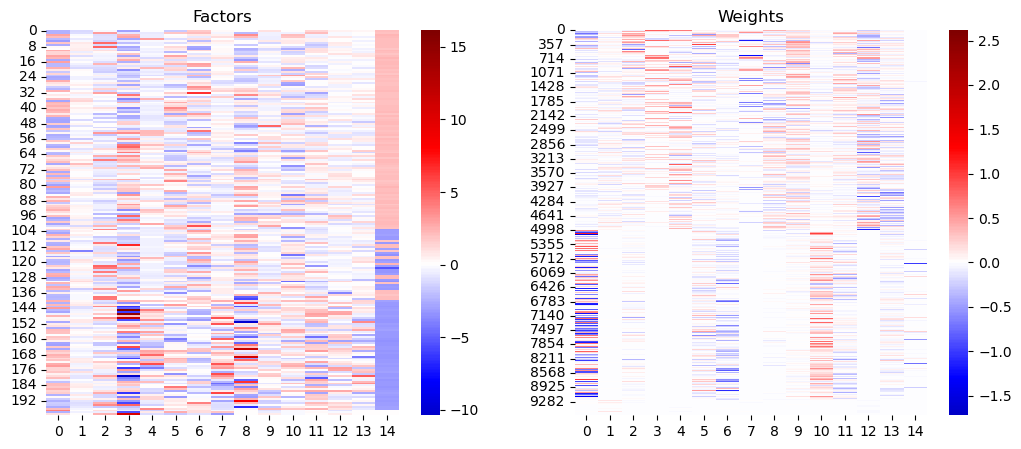

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12.5, 5))
sns.heatmap(model.get_factors(), ax=ax[0], cmap="seismic", center=0)
sns.heatmap(model.get_weights(), ax=ax[1], cmap="seismic", center=0)
ax[0].set_title("Factors")
ax[1].set_title("Weights")

##### Factor Correlation

A good sanity check is to verify that the Factors are largely uncorrelated. In MOFA there are no orthogonality constraints such as
in Principal Component Analysis, but if there is a lot of correlation between Factors this suggests a poor model fit. Reasons?
Perhaps you used too many factors or perhaps the normalisation is not adequate.

<Axes: >

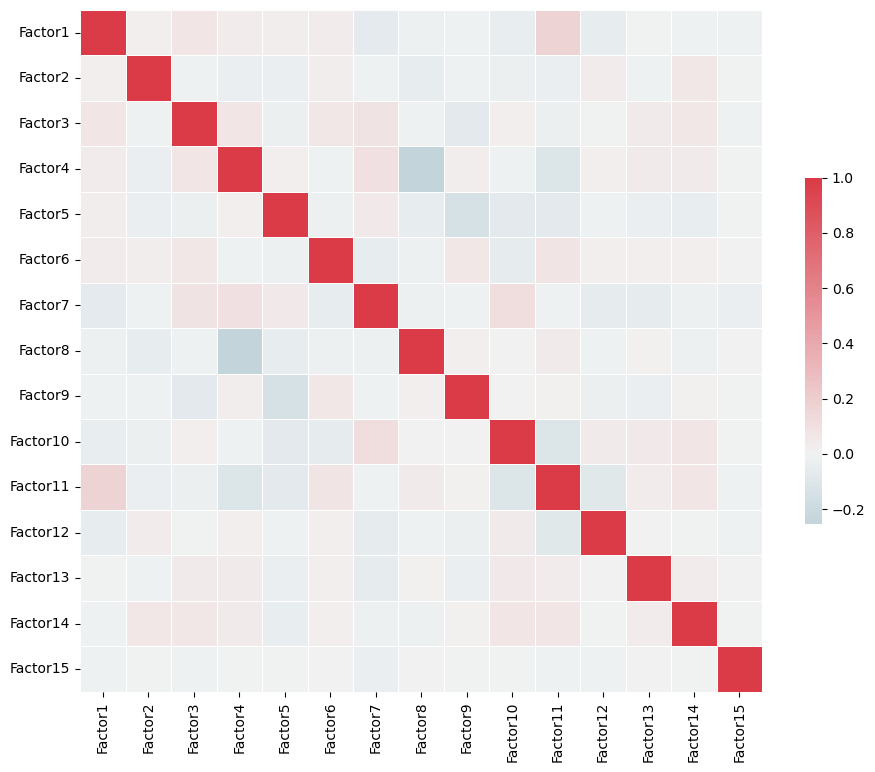

In [27]:
mfx.plot_weights_correlation(model)

##### Variance Explained

The most important insight that MOFA generates is the variance decomposition analysis. This plot shows the percentage of
variance explained by each factor across each data modality (and group, if provided). It summarises the source
of variation from a complex heterogeneous data set in a single figure.

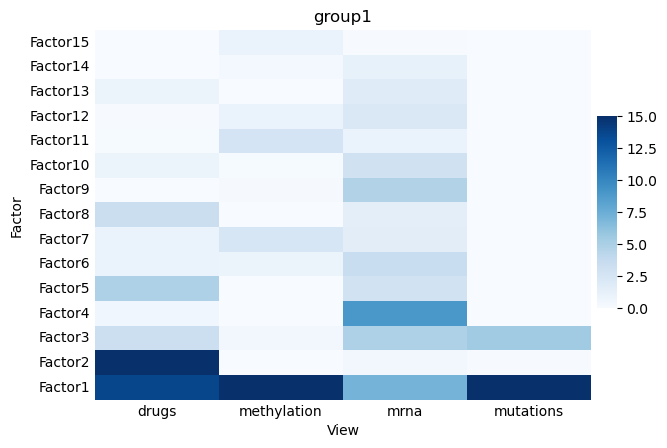

In [28]:
mfx.plot_r2(model, vmax=15, x="View")

What insights from the data can we learn just from inspecting this plot?

    Factor 1 captures a source of variability that is present across all data modalities. Thus, its etiology is likely to be something very important for the disease
    Factor 2 captures a very strong source of variation that is exclusive to the drug response data.
    Factor 4 captures variation that is present across multiple data modalities, except for DNA methylation. This is likely to be important too.
    Factor 3 is capturing some co-variation between the mRNA and the drug response assay.


### <span style="color:red">Questions</span>

Based on the MOFA output, if you were to profile just one molecular layer, which one would you choose to maximise the amount of sources of variation captured?

While trying to annotate factors, a global overview of top features defining them could be helpful.

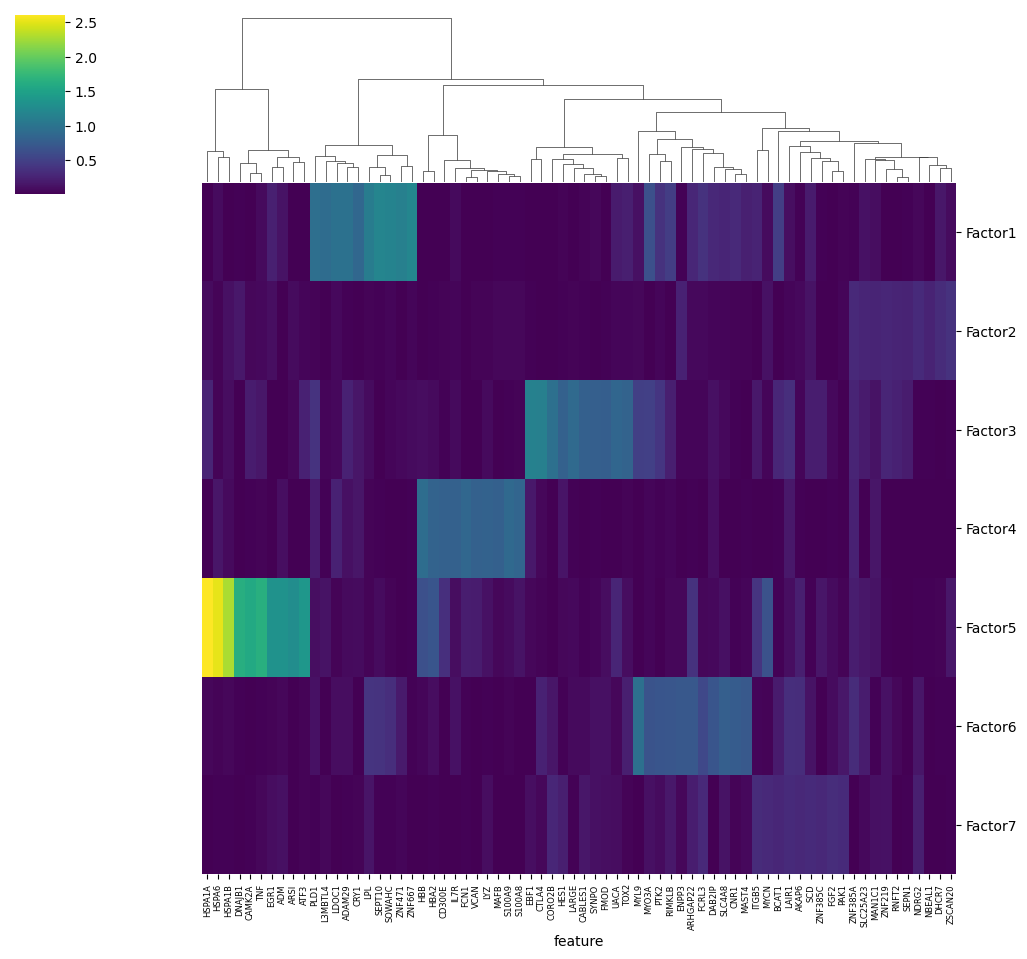

In [29]:
mfx.plot_weights_heatmap(
    model,
    # n_features=5,
    view=0,
    factors=range(0, 7),
    xticklabels_size=6,
    w_abs=True,
    cmap="viridis",
    cluster_factors=False,
)

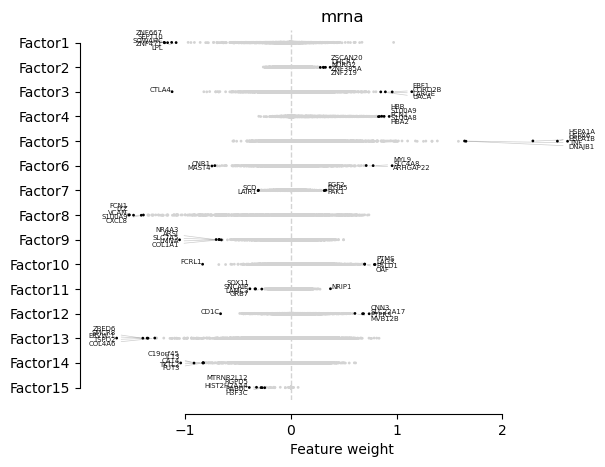

In [30]:
ax = mfx.plot_weights(
    model,
    views="mrna",
    factor=0,
    n_features=5,
    y_repel_coef=0.04,
    x_rank_offset=-150,
)

### Analysis: Factor 1 | "Give it a Name"

Ways to understande the underlying signal of a factor:  
    - association between the metadata and the factor values  
    - inspection of factor values  
    - inspection of feature weights  
    - GSEA of the mRNA weights  

Each factor captures a different source of variability in the data. Mathematically, each Factor is defined by a linear combination of the input features. Each Factor ordinates cells along a one-dimensional axis that is centered at zero. Samples with different signs manifest opposite phenotypes along the inferred axis of variation, with higher absolute value indicating a stronger effect.
Note that the interpretation of MOFA factors is analogous to the interpretation of the principal components in PCA.

<Axes: >

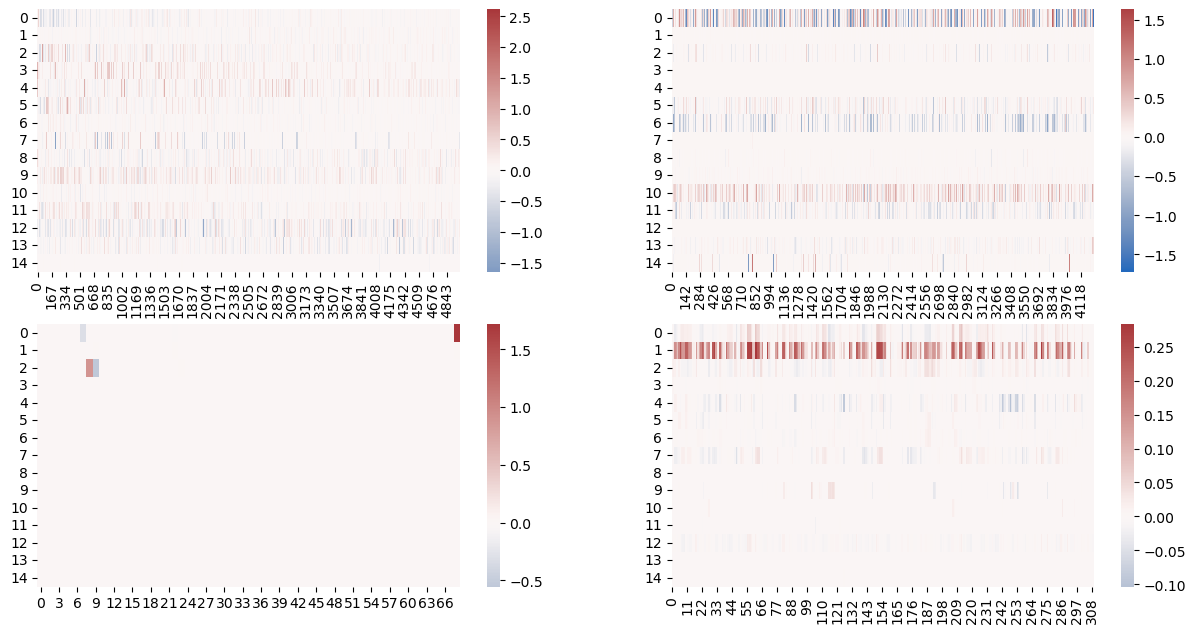

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(15, 7.5))
sns.heatmap(model.get_weights(["mrna"]).T, center=0, cmap="vlag", ax=ax[0, 0])
sns.heatmap(model.get_weights(["methylation"]).T, center=0, cmap="vlag", ax=ax[0, 1])
sns.heatmap(model.get_weights(["mutations"]).T, center=0, cmap="vlag", ax=ax[1, 0])
sns.heatmap(model.get_weights(["drugs"]).T, center=0, cmap="vlag", ax=ax[1, 1])

#### Association analysis

Let's test for associations between the MOFA factors and some of the covariates:


<Axes: >

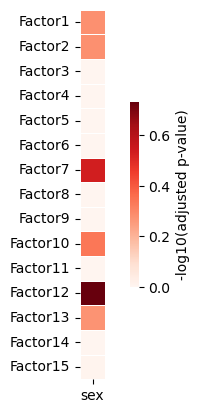

In [32]:
# Compute log10 of the p-values between factors and covariates
mfx.plot_factors_covariates_correlation(
    model, covariates=mdata.obs[["sex"]], pvalues=True
)

E.g. `sex` shows an associations with the survival outcome (whether the patients were deceased). 
We will explore association with clinical measurements later in the tutorial.  

#### Inspection of factor values


How do we interpret the factor values?
Each factor captures a different source of variability in the data. Mathematically, each Factor is defined by a linear combination of the input features. As the data is centered prior to running MOFA, each Factor ordinates cells along a one-dimensional axis that is centered at zero. Samples with different signs manifest opposite phenotypes along the inferred axis of variation, with higher absolute value indicating a stronger effect. Note that the interpretation of MOFA factors is analogous to the interpretation of the principal components in PCA.

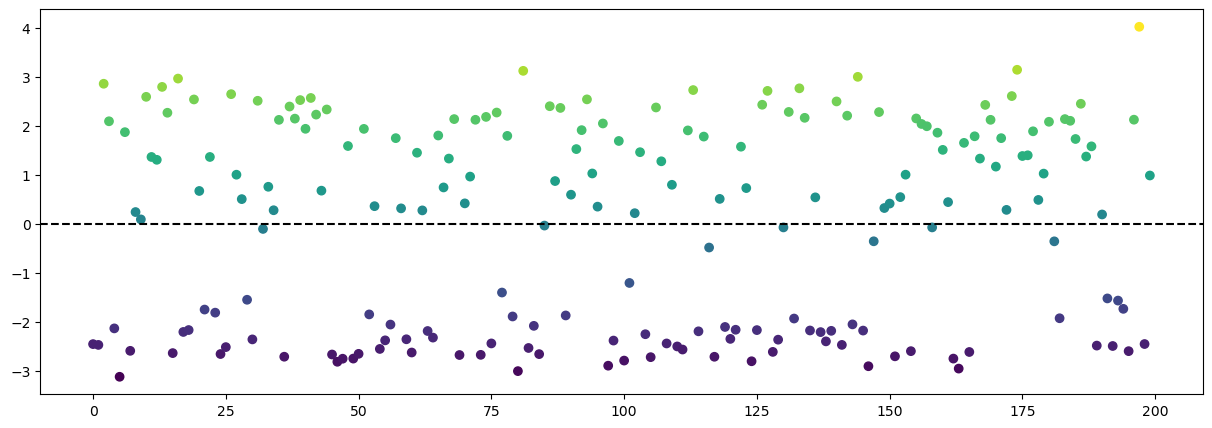

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
weights_fac_0 = model.get_factors(df=True).iloc[:, 0]
plt.scatter(range(200), weights_fac_0, c=weights_fac_0)
ax.axhline(0, color="k", linestyle="--")

#### Inspection of feature weights


By looking at the variance explained plot, we saw that Factor 1 captures variation in all data modalities. Out of all omics, the somatic mutation data is a good place to start, as somatic mutations are very sparse, easy to interpret and any change in the DNA is likely to have downstream consequences to all other molecular layers. Let’s plot the weights:

**How do we interpret the feature weights?**  
The weights provide a score for each feature on each factor. Features with no association with the corresponding factor are expected to have values close to zero, whereas features with strong association with the factor are expected to have large absolute values. The sign of the weights indicates the direction of the effect: a positive weights indicates that the feature has higher levels in the cells with positive factor values, and vice-versa. 

#### Plot feature weights for somatic mutations

By looking at the variance explained plot, we saw that Factor 1 captures variation in all data modalities. Out of all omics, the somatic mutation data is a good place to start, as somatic mutations are very sparse, easy to interpret and any change in the DNA is likely to have downstream consequences to all other molecular layers. Let's plot the weights:

<Axes: title={'center': 'mutations'}, xlabel='Feature weight'>

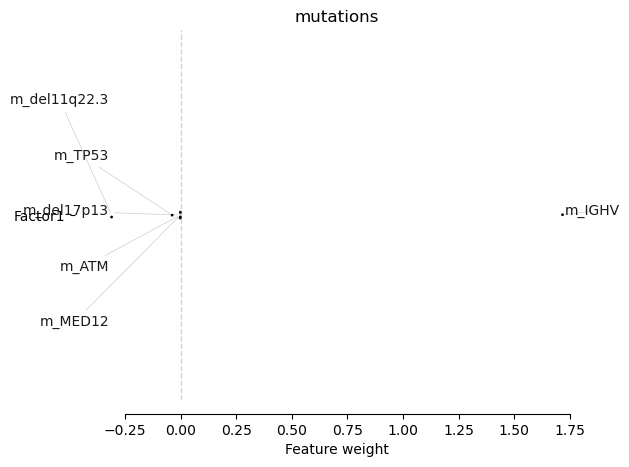

In [34]:
mfx.plot_weights(
    model,
    views=["mutations"],
    factors=0,
    zero_line=True,
    ncols=1,
    label_size=10,
    n_features=6,
)

Notice that most features lie at zero, indicating that most features have no association with Factor 1. There is however one gene that clearly stands out: IGHV (immunoglobulin heavy chain variable region). [This is the main clinical marker for CLL](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6355490/).  

IGHV has a positve weight. This means that samples with positive Factor 1 values have IGHV mutation whereas samples with negative Factor 1 values do not have the IGHV mutation. To confirm this, let’s plot the Factor values and colour the IGHV mutation status.

In [335]:
model.metadata

,group,Gender,IGHV,TTD,TTT,age,died,sex,treatedAfter,trisomy12
sample,,,,,,,,,,
H045,group1,m,0.0,1.973990,0.021903,90.731507,1.0,0,True,0.0
H109,group1,m,0.0,1.571526,1.571526,85.465753,0.0,0,False,1.0
H024,group1,m,NaN,NaN,NaN,NaN,NaN,0,nan,NaN
H056,group1,m,1.0,3.074606,3.074606,83.468493,0.0,0,False,0.0
H079,group1,m,0.0,2.269678,0.821355,47.898630,0.0,0,True,0.0
...,...,...,...,...,...,...,...,...,...,...
H175,group1,m,0.0,0.906229,0.366872,61.597260,0.0,0,True,0.0
H179,group1,m,1.0,0.651608,0.651608,60.687671,0.0,0,False,0.0
H050,group1,f,1.0,1.013005,1.013005,62.646575,0.0,1,False,0.0


<Axes: xlabel='IGHV', ylabel='Factor1'>

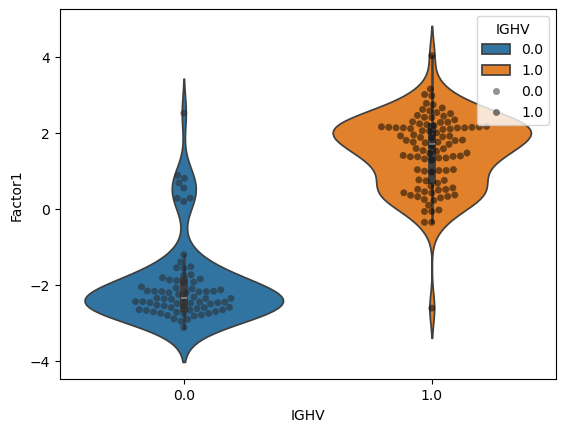

In [35]:
df_plot = pd.merge(
    model.get_factors(df=True).iloc[:, 0],
    model.metadata.IGHV,
    left_index=True,
    right_index=True,
)

sns.violinplot(x="IGHV", y="Factor1", data=df_plot, hue="IGHV")
sns.swarmplot(x="IGHV", y="Factor1", data=df_plot, hue="IGHV", color="k", alpha=0.5)

#### Plot gene weights for mRNA expression


From the variance explained plot we know that Factor 1 drives variation across all data modalities. Let’s visualise the mRNA expression changes that are associated with Factor 1:

<Axes: title={'center': 'mrna'}, xlabel='Feature weight'>

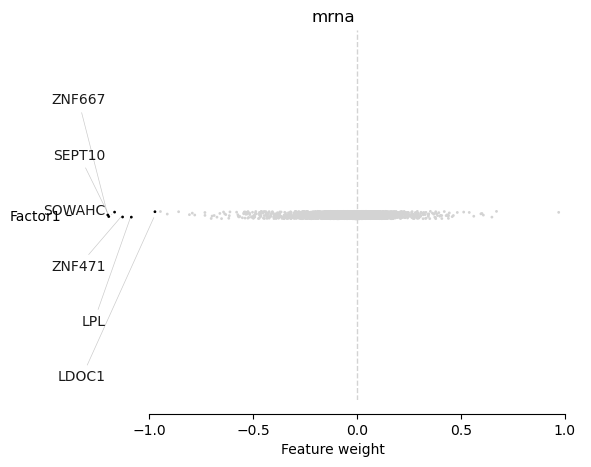

In [36]:
mfx.plot_weights(
    model,
    views=["mrna"],
    factors=0,
    zero_line=True,
    ncols=1,
    label_size=10,
    n_features=6,
)

#### Plot molecular signatures in the input data 


In this case we have a large amount of genes that have large positive and negative weights. Genes with large positive values will be more expressed in the samples with IGHV mutation, whereas genes with large negative values will be more expressed in the samples without the IGHV mutation. 

<Axes: xlabel='Factor1', ylabel='ZNF667'>

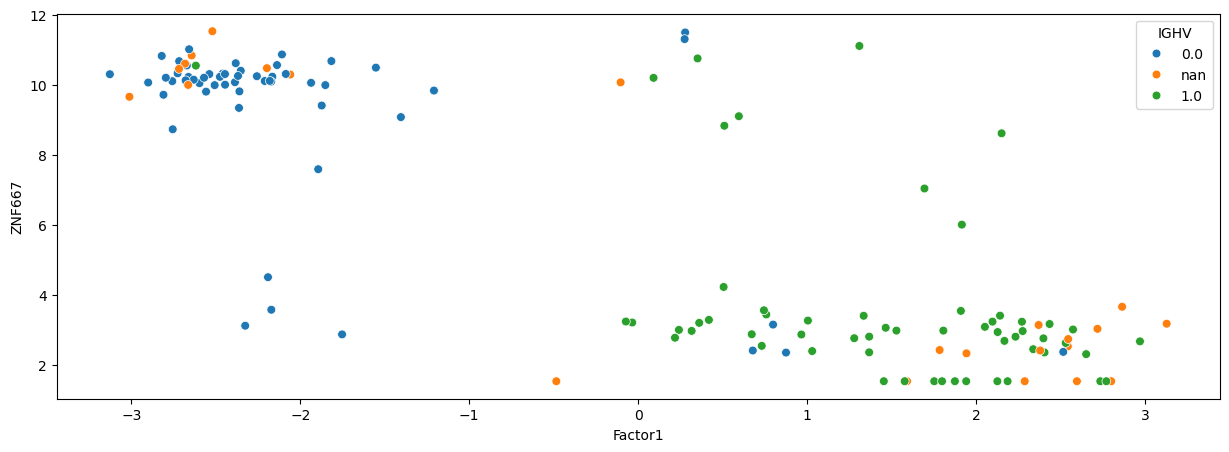

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
weights_fac_1 = model.get_factors(df=True).iloc[:, 0]
df_plot = pd.DataFrame(
    mdata.mod["mrna"].X,
    columns=mdata.mod["mrna"].var_names,
    index=mdata.mod["mrna"].obs_names,
)
df_plot = df_plot[["ZNF667"]]
df_plot = pd.merge(
    df_plot, model.get_factors(df=True).iloc[:, 0], left_index=True, right_index=True
)
df_plot = pd.merge(df_plot, metadata[["IGHV"]], left_index=True, right_index=True)
df_plot["IGHV"] = df_plot["IGHV"].astype(str)

sns.scatterplot(y="ZNF667", x="Factor1", data=df_plot, hue="IGHV", s=40)

<Axes: xlabel='IGHV', ylabel='Factor1'>

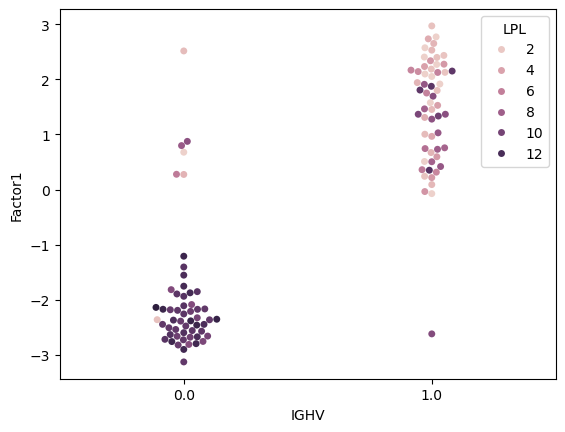

In [38]:
# Plot distribution of LPL for different IGHV status
df_plot = pd.merge(
    model.get_factors(df=True).iloc[:, 0],
    model.metadata.IGHV,
    left_index=True,
    right_index=True,
)
# Join the expression of LPL gene for each sample
df_plot = pd.merge(
    df_plot,
    pd.DataFrame({"LPL": mrna[:, "LPL"].X.squeeze()}, index=mrna.obs.index),
    left_index=True,
    right_index=True,
)

sns.swarmplot(x="IGHV", y="Factor1", data=df_plot, hue="LPL")

<Axes: title={'center': 'drugs'}, xlabel='Feature weight'>

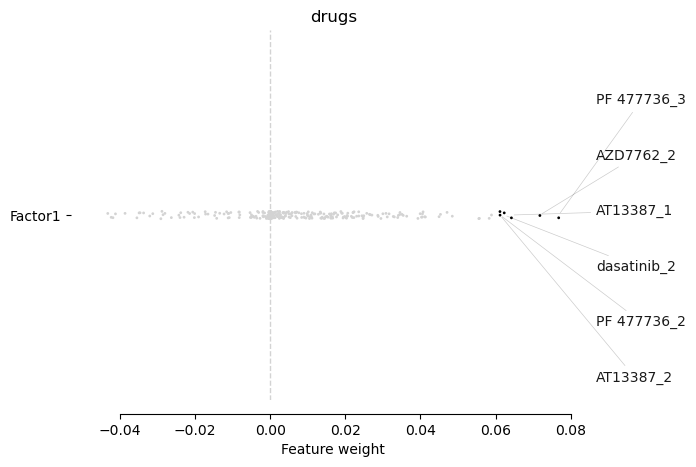

In [39]:
mfx.plot_weights(
    model,
    views=["drugs"],
    factors=0,
    zero_line=True,
    ncols=1,
    label_size=10,
    n_features=6,
)

Focusing on the drug response, we notice PF477736 (D_078), AZD7762 (D_020), AT13387 (D_017), and dasatinib (D_050) have the major association with this factor. Those are the exact top associations with the IGHV status described in the original paper:

"Indeed, the strongest associations of response with IGHV status were observed for dasatinib
and for 3 of the drugs already discussed above, the HSP90 inhibitor
AT13387 and the CHEK inhibitors PF477736 and AZD7762. These
results show how the critical role of BCR signaling renders CLL
cells sensitive to a broad range of kinase inhibitors that act by mul-
tiple target engagement of BCR components." from https://www.huber.embl.de/pub/pdf/Dietrich2018.pdf 

### GSEA

In addition to exploring the individual weights for each factor, we can use enrichment analysis to look for significant associations of factors to genesets.

In [40]:
import gseapy as gp
from gseapy import barplot, dotplot
from tqdm import tqdm

In [41]:
factor_values = model.get_weights(["mrna"])[:, 3]
# Get gene names of all genes with a weight > 0.6
gene_list = list(mrna.var_names[np.abs(factor_values) > 0.7])

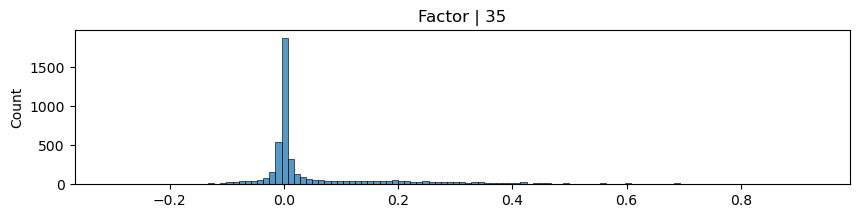

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
sns.histplot(factor_values, ax=ax)
ax.set_title(f"Factor | {len(gene_list)}")
plt.show()

In [43]:
# # load reactome data
# gsreactome = pd.read_csv("data/rgs.csv", sep=" ")

# # Convert gsreactome to dict with rows as keys and lists of genes as values if value > 0
# gs_dict = {}
# for i in range(gsreactome.shape[0]):
#     gs_dict[gsreactome.index[i]] = list(gsreactome.columns[gsreactome.iloc[i, :] > 0])
# # Replace ensemble ids with gene names
# for k, v in tqdm(gs_dict.items()):
#     elements = []
#     for gene in v:
#         try:
#             elements.append(gene_ids.loc[gene_ids["GENEID"] == gene, "SYMBOL"].item())
#         except:
#             pass

#     # cols = [gene_ids.loc[gene_ids["GENEID"] == gene, "SYMBOL"].item() for gene in v]
#     gs_dict[k] = elements

# for db in [
#     "Reactome_2015",
#     "MSigDB_Hallmark_2020",
#     "KEGG_2021_Human",
# ]:  # gs_dict, "MSigDB_Hallmark_2020", "Reactome_2015"
#     # print(f"Database: {db}")
#     for factor in [1]:
#         for cutoff in [0.2, 0.4, 0.6, 0.8]:
#             print(f"Factor: {factor} | Cutoff: {cutoff}")
#             try:
#                 factor_values = model.get_weights(["mrna"])[:, factor]
#                 gene_list = list(mrna.var_names[np.abs(factor_values) > cutoff])

#                 # if you are only intrested in dataframe that enrichr returned, please set outdir=None
#                 enr = gp.enrichr(
#                     gene_list=gene_list,
#                     gene_sets=db,  # "MSigDB_Hallmark_2020", "KEGG_2021_Human", "Reactome_2015"
#                     # organism="human",
#                     outdir=None,
#                     cutoff=0.05,
#                     # background="hsapiens_gene_ensembl",
#                 )

#                 # Sort by adjusted p-value
#                 terms = enr.results.sort_values("Adjusted P-value")
#                 terms = terms[terms["Adjusted P-value"] < 0.05]
#                 # Filter for terms with "stress" in term
#                 terms = terms[
#                     terms["Term"].str.contains("stress")
#                     | terms["Term"].str.contains("Stress")
#                 ]
#                 if len(terms) > 0:
#                     print(terms)
#             except:
#                 pass

# ax = barplot(
#     enr.results,
#     column="Adjusted P-value",
#     group="Gene_set",  # set group, so you could do a multi-sample/library comparsion
#     size=10,
#     top_term=5,
#     figsize=(3, 5),
#     color={
#         "MSigDB_Hallmark_2020": "red",
#         "KEGG_2021_Human": "blue",
#         "Reactome_2013": "green",
#     },
# )

### End

In [46]:
# it's always a good idea to close the model after using it
# model.close()

# Can you suggest new RNA expression and DNA methylation markers for personalised treatment recommendations according to Factor 1 (the IGHV status)?

MannwhitneyuResult(statistic=2804.0, pvalue=3.7990718551713795e-12)

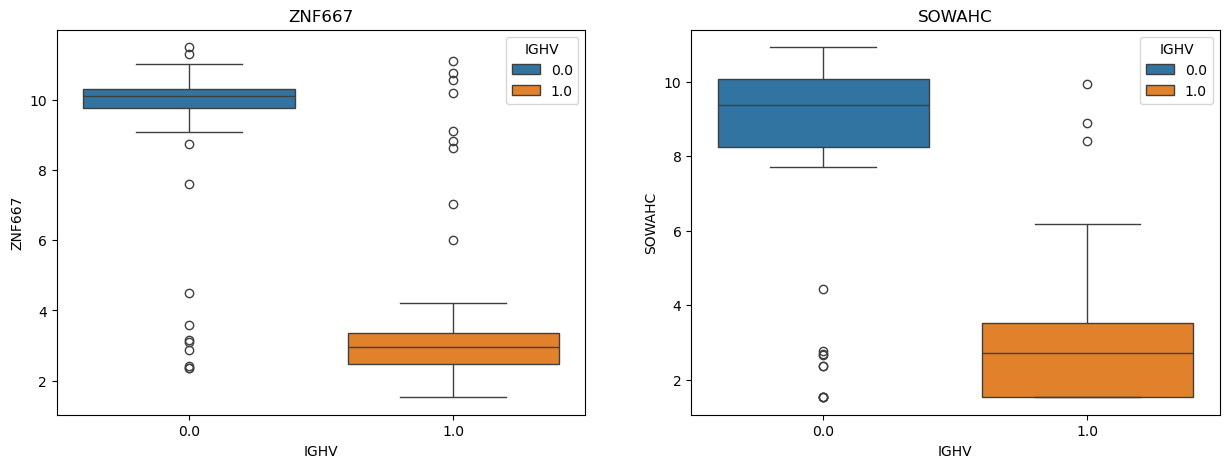

In [272]:
from scipy.stats import mannwhitneyu

df = pd.DataFrame(
    mrna[:, ["ZNF667", "SOWAHC"]].X, index=mrna.obs_names, columns=["ZNF667", "SOWAHC"]
)
df = df.join(mdata.obs.IGHV)

df["IGHV"] = df["IGHV"].astype(float)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x="IGHV", y="ZNF667", data=df, ax=ax[0], hue="IGHV")
sns.boxplot(x="IGHV", y="SOWAHC", data=df, ax=ax[1], hue="IGHV")
ax[0].set_title("ZNF667")
ax[1].set_title("SOWAHC")

mannwhitneyu(
    x=df.loc[df.IGHV == 0, "ZNF667"].values, y=df.loc[df.IGHV == 1, "ZNF667"].values
)

## Inspection of Factor 2/3

<Axes: title={'center': 'mutations'}, xlabel='Feature weight'>

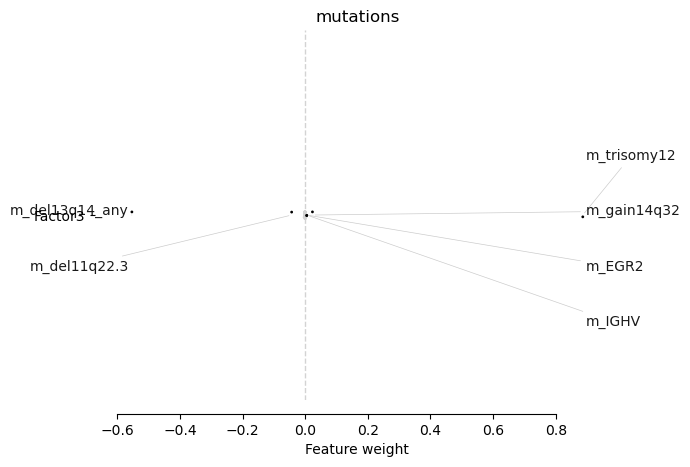

In [47]:
mfx.plot_weights(
    model,
    views=["mutations"],
    factors=2,
    zero_line=True,
    ncols=1,
    label_size=10,
    n_features=6,
)

Looking at the results, we see a large absolute value in trisomy 12, which is a common mutation in CLL. This is a good sign that the model is capturing the biology of the disease. See further: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6058775/

In [174]:
#
# Run mrna marker
#
mrnas = model.get_weights(["mrna"])[:, 2]
# Get index of top 5 genes
top5 = np.argsort(mrnas)[-10:]
print("MAX: ", mrna.var_names[top5])
top5 = np.argsort(mrnas)[:10]
print("MIN: ", mrna.var_names[top5])

MAX:  Index(['DIRAS1', 'ADD2', 'EML6', 'PPP1R14A', 'SYNPO', 'HES1', 'UACA', 'LARGE',
       'CORO2B', 'EBF1'],
      dtype='object')
MIN:  Index(['CTLA4', 'TOX2', 'CABLES1', 'FMOD', 'MAP6', 'CTTN', 'GTSF1L', 'PDGFD',
       'IGSF3', 'APOD'],
      dtype='object')


Text(0.5, 1.0, 'CTLA4')

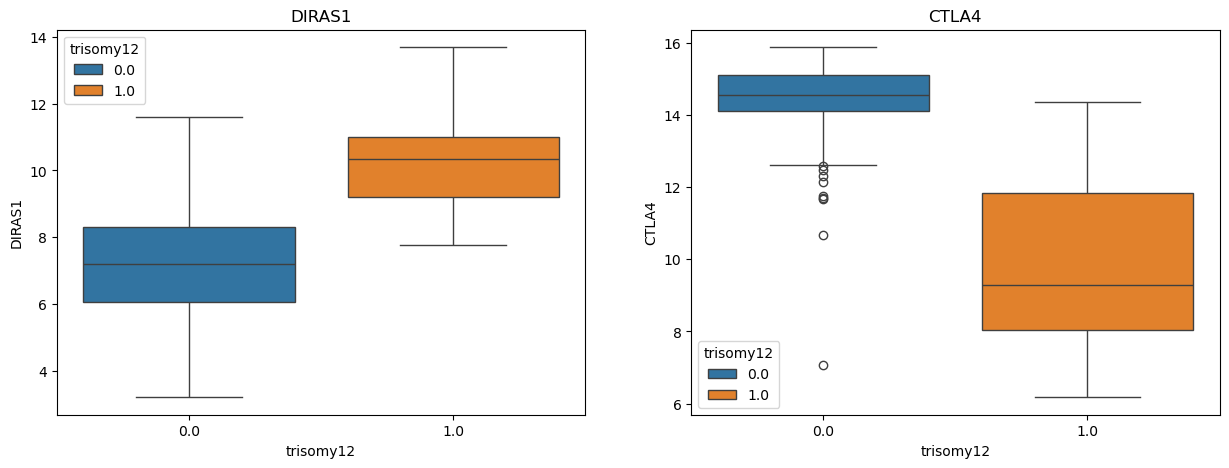

In [236]:
from scipy.stats import mannwhitneyu

df = pd.DataFrame(
    mrna[:, ["DIRAS1", "CTLA4"]].X, index=mrna.obs_names, columns=["DIRAS1", "CTLA4"]
)
df = df.join(mdata.obs.trisomy12)

df["trisomy12"] = df["trisomy12"].astype(float)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x="trisomy12", y="DIRAS1", data=df, ax=ax[0], hue="trisomy12")
sns.boxplot(x="trisomy12", y="CTLA4", data=df, ax=ax[1], hue="trisomy12")
ax[0].set_title("DIRAS1")
ax[1].set_title("CTLA4")

## GSEA | Factor 5

In [241]:
for db in [
    "Reactome_2015",
    "MSigDB_Hallmark_2020",
    # "KEGG_2021_Human",
]:
    try:
        factor_values = model.get_weights(["mrna"])[:, 4]
        gene_list = list(mrna.var_names[np.abs(factor_values) > 0.2])

        # if you are only intrested in dataframe that enrichr returned, please set outdir=None
        enr = gp.enrichr(
            gene_list=gene_list,
            gene_sets=db,
            organism="human",
            outdir=None,
            cutoff=0.05,
        )

        # Sort by adjusted p-value
        terms = enr.results.sort_values("Adjusted P-value")
        terms = terms[terms["Adjusted P-value"] < 0.05]
        display(terms.head(10))
    except:
        pass

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,Reactome_2015,Cellular responses to stress,39/247,4.952866e-09,0.000005,0,0,3.219756,61.572362,HIST1H2BN;CDKN1A;CAMK2D;CXCL8;HIST1H2BJ;MRPL18...
1,Reactome_2015,HSF1-dependent transactivation,13/34,1.631454e-08,0.000007,0,0,10.485988,188.026442,HSPA8;CAMK2D;HSP90AA1;HSPA1L;MRPL18;CAMK2A;HSP...
2,Reactome_2015,Senescence-Associated Secretory Phenotype (SASP),19/75,2.205919e-08,0.000007,0,0,5.767551,101.679244,HIST1H2BN;CDKN1A;JUN;CDKN2B;CXCL8;CDKN2C;HIST1...
3,Reactome_2015,Attenuation phase,11/26,6.058142e-08,0.000012,0,0,12.403528,206.137668,DNAJB1;HSPA8;HSP90AA1;HSPH1;HSPA1L;MRPL18;HSPA...
4,Reactome_2015,DNA methylation,12/32,7.554076e-08,0.000012,0,0,10.154758,166.523742,HIST1H2BN;DNMT3L;HIST1H2BJ;HIST1H2BL;HIST1H2BK...
5,Reactome_2015,DNA Damage/Telomere Stress Induced Senescence,16/58,7.779935e-08,0.000012,0,0,6.463149,105.796141,HIST1H2BN;CDKN1A;HIST1H2BJ;HIST1H2BL;H2AFX;HIS...
6,Reactome_2015,Chemokine receptors bind chemokines,15/55,2.335443e-07,0.000032,0,0,6.357111,97.072408,CXCL8;CCL22;CCL20;CXCL1;CXCR6;CXCL16;CXCL10;CX...
7,Reactome_2015,RNA Polymerase I Promoter Opening,11/30,3.476679e-07,0.000042,0,0,9.790182,145.599761,HIST1H2BN;HIST1H2BJ;HIST1H2BL;HIST1H2BK;H2AFX;...
8,Reactome_2015,Class A/1 (Rhodopsin-like receptors),41/313,4.204265e-07,0.000045,0,0,2.584311,37.942851,PTGER4;OXTR;CXCL8;PTAFR;RXFP4;CXCL1;LPAR4;CXCR...
9,Reactome_2015,Packaging Of Telomere Ends,11/31,5.115202e-07,0.000047,0,0,9.300179,134.721272,HIST1H2BN;HIST1H2BJ;HIST1H2BL;HIST1H2BK;H2AFX;...


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,68/200,3.565765e-35,1.782882e-33,0,0,9.125680,723.840741,CDKN1A;CSF1;TNFAIP6;CD80;SERPINE1;PLEK;TNFAIP3...
1,MSigDB_Hallmark_2020,Inflammatory Response,53/200,6.682867e-22,1.670717e-20,0,0,6.292555,306.808151,CDKN1A;CSF3R;CXCL8;CSF1;TNFAIP6;ITGB3;AQP9;SER...
2,MSigDB_Hallmark_2020,Hypoxia,40/200,1.784131e-12,2.973551e-11,0,0,4.308011,116.540702,CDKN1C;PPP1R15A;ERRFI1;CDKN1A;SDC4;CITED2;SERP...
3,MSigDB_Hallmark_2020,IL-2/STAT5 Signaling,35/199,1.684333e-09,2.105416e-08,0,0,3.659934,73.937604,CDKN1C;CSF1;RGS16;FGL2;COCH;NT5E;PNP;SOCS1;CA2...
4,MSigDB_Hallmark_2020,p53 Pathway,33/200,2.498258e-08,2.498258e-07,0,0,3.382061,59.203275,PPP1R15A;CDKN1A;PCNA;RRAD;RGS16;IFI30;TOB1;PIT...
5,MSigDB_Hallmark_2020,IL-6/JAK/STAT3 Signaling,20/87,5.563402e-08,4.636169e-07,0,0,5.075976,84.791499,JUN;CSF3R;CSF1;TNFRSF12A;ITGA4;ITGB3;IL1R2;CXC...
6,MSigDB_Hallmark_2020,Epithelial Mesenchymal Transition,32/200,8.514043e-08,6.081459e-07,0,0,3.256899,53.018943,OXTR;SPARC;CXCL8;SDC4;ITGB5;LAMA2;ITGB3;SERPIN...
7,MSigDB_Hallmark_2020,Myogenesis,29/200,2.696926e-06,1.348463e-05,0,0,2.891389,37.077433,CHRNA1;ACHE;CDKN1A;SPARC;ITGB5;LAMA2;ATP2A1;CN...
8,MSigDB_Hallmark_2020,Interferon Gamma Response,29/200,2.696926e-06,1.348463e-05,0,0,2.891389,37.077433,CD274;CDKN1A;TNFAIP6;FGL2;TNFAIP3;IFIT1;IFI30;...
9,MSigDB_Hallmark_2020,Allograft Rejection,29/200,2.696926e-06,1.348463e-05,0,0,2.891389,37.077433,ACHE;DYRK3;CSF1;CD80;CD1D;CD3E;TNF;ICAM1;IL18R...


### (Q) Which drugs are associated with Factor 4? What is their target pathway? Do they make biological sense?

In [383]:
#
# Get highly activated drugs
#
w_drugs = model.get_weights(["drugs"])[:, 4]
# Get index of top 5 drugs
top5 = np.argsort(w_drugs)[:10]
print("MAX: ", drugs.var_names[top5])

MAX:  Index(['SD51_4', 'BAY 11-7085_2', 'SD07_3', 'MIS-43_4', 'MIS-43_3', 'SD07_4',
       'doxorubicine_3', 'NU7441_1', 'enzastaurin_1', 'CCT241533_2'],
      dtype='object')


Out of the 5 top drugs, the target category for 3 of them is Reactive Oxygen Species, which are closely related to stress response mechanisms.

In [359]:
df = pd.DataFrame()
for drug in ["SD51", "BAY", "SD07", "MIS-43", "NU7441"]:
    x = drug_names.loc[drug_names["name"].str.contains(drug), :]
    df = pd.concat([df, x], axis=0)

df

,name,main_targets,target_category,pathway
drug_id,,,,
D_141,SD51,ROS,Reactive oxygen species,Reactive oxygen species
D_041,BAY 11-7085,NFkB,NFkB,Other
D_127,SD07,ROS,Reactive oxygen species,Reactive oxygen species
D_149,MIS-43,ROS,Reactive oxygen species,Reactive oxygen species
D_032,NU7441,DNAPK,DNA damage response,Other


## Plot Factor 1 vs Factor 3

Next, we will see how many patients have missing information wrt to their IGHV and trisomy12 status. 
Looking at the plots already reveals that both mutations allow us to separate the patients into four different subgroups.

<Axes: xlabel='Factor1', ylabel='Factor3'>

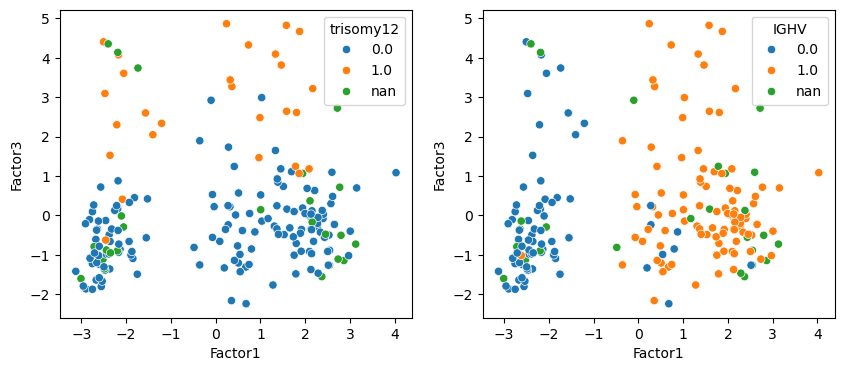

In [67]:
# Make a scatterplot of factor 1 vs factor 3
f1 = model.get_factors(df=True).iloc[:, [0, 2]]
# Make category from mdata.obs.trisomy12
f1["trisomy12"] = mdata.obs.trisomy12.astype(str).astype("category")
f1["IGHV"] = mdata.obs.IGHV

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(x="Factor1", y="Factor3", data=f1, hue="trisomy12", ax=ax[0])
sns.scatterplot(x="Factor1", y="Factor3", data=f1, hue="IGHV", ax=ax[1])

## Impute missing covariates

Now, we will train a Random Forest to impute the missing mutations. We use factor 1 and 3 as our independent variables.

<Axes: xlabel='Factor1', ylabel='Factor3'>

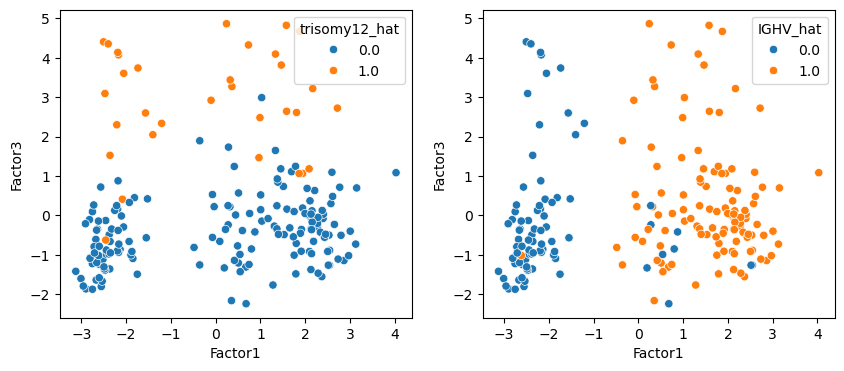

In [278]:

# Train Random Forest model
from sklearn.ensemble import RandomForestClassifier

f1 = model.get_factors(df=True).iloc[:, [0, 2]]
f1["trisomy12"] = mdata.obs.trisomy12.astype(float)
f1["IGHV"] = mdata.obs.IGHV.astype(float)
# Remove rows with missings in trisomy12 or IGHV
f1_train = f1.dropna()

# Train Random Forest model
X = f1_train[["Factor1", "Factor3"]].values
y = f1_train["IGHV"].values

clf = RandomForestClassifier(random_state=42)
clf.fit(X, y)

f1["IGHV_hat"] = clf.predict(f1[["Factor1", "Factor3"]].values)

# Train Random Forest model
X = f1_train[["Factor1", "Factor3"]].values
y = f1_train["trisomy12"].values

clf = RandomForestClassifier(random_state=42)
clf.fit(X, y)

f1["trisomy12_hat"] = clf.predict(f1[["Factor1", "Factor3"]].values)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(x="Factor1", y="Factor3", data=f1, hue="trisomy12_hat", ax=ax[0])
sns.scatterplot(x="Factor1", y="Factor3", data=f1, hue="IGHV_hat", ax=ax[1])

### Drug Effects wrt to IGHV status
We observse that some drugs have a different effect on the cell viability depending on the IGHV status: this is a key indicator that knowing a patient's IGHV status allows us to make better personalised treatmenent recommendations.

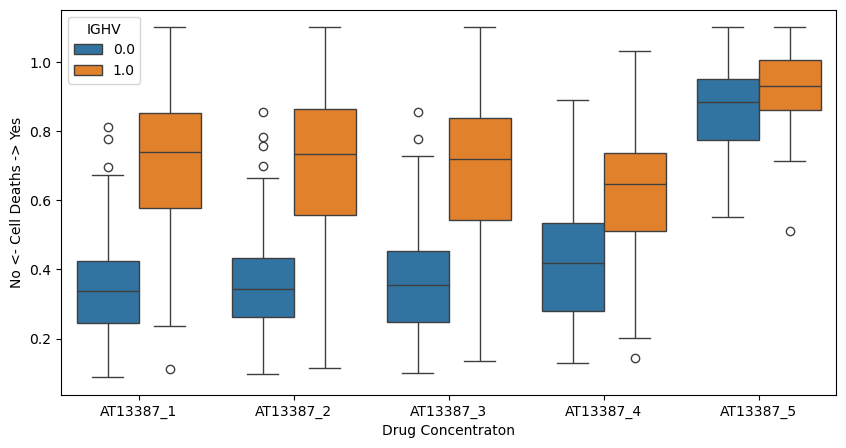

In [338]:
drug = "AT13387"
X = datasets.loc[:, datasets.columns.str.contains(drug)]
# Add ighv status to X
X = X.join(mdata.obs["IGHV"])
X = X.melt(id_vars="IGHV")
# Drop all rows with nans
X["IGHV"] = X["IGHV"].astype(float)
X = X.dropna()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.boxplot(x="variable", y="value", data=X, hue="IGHV")
ax.set_xlabel("Drug Concentraton")
ax.set_ylabel("No <- Cell Deaths -> Yes");